## Ingest scraped data

In [119]:
import pandas as pd
import numpy as np
indeed_posts_df = pd.read_csv('indeed/data/indeed_spider.csv')
redirects_df = pd.read_csv('indeed/data/redirect_spider.csv')

## Join the data sets together

In [120]:
indeed_df = indeed_posts_df.join(redirects_df, rsuffix='_red', how='left').drop('original_url_red',axis=1)

## Transform Posted Date field to DateTime

In [121]:
indeed_df['post_date'] = pd.to_datetime(indeed_df['post_date'])

## Create feature to see if job is remote

In [122]:
indeed_df['remote'] = indeed_df['job_location'].str.contains('remote', case=False, regex=False)

In [123]:
indeed_df['posted_days_ago'] = (max(indeed_df['post_date']) - indeed_df['post_date'])/np.timedelta64(1,'D')

## Normalize non-annual salaries to annual salaries 

In [128]:
salary_mask = np.logical_not(indeed_df['salary'].isna())
jobs.loc[salary_mask, 'salary_interim'] = jobs.loc[salary_mask, 'salary'].apply(lambda wd: wd.split(' ')[-1])

In [129]:
jobs['salary_interim'].unique()

array([nan, 'year', 'hour', 'month'], dtype=object)

In [124]:
salary_mask = np.logical_and(np.logical_not(indeed_df['salary'].isna()),indeed_df['salary'].str.endswith('hour'))
HOURLY_TO_ANNUAL_MULTIPLE = 2000
indeed_df.loc[salary_mask, 'job_salary_low'] = indeed_df['job_salary_low'] * HOURLY_TO_ANNUAL_MULTIPLE
indeed_df.loc[salary_mask, 'job_salary_high'] = indeed_df['job_salary_high'] * HOURLY_TO_ANNUAL_MULTIPLE


salary_mask = np.logical_and(np.logical_not(indeed_df['salary'].isna()),indeed_df['salary'].str.endswith('month'))
MONTHLY_TO_ANNUAL_MULTIPLE = 12
indeed_df.loc[salary_mask, 'job_salary_low'] = indeed_df['job_salary_low'] * MONTHLY_TO_ANNUAL_MULTIPLE
indeed_df.loc[salary_mask, 'job_salary_high'] = indeed_df['job_salary_high'] * MONTHLY_TO_ANNUAL_MULTIPLE

## Job Salary Statistics

In [125]:
indeed_df.loc[np.logical_not(indeed_df['salary'].isna())][['job_salary_low', 'job_salary_high']].describe()

,job_salary_low,job_salary_high
count,97.000000,97.000000
mean,115621.494845,145044.474227
std,45894.943073,63091.692807
min,20000.000000,20000.000000
25%,80750.000000,103309.000000
50%,114700.000000,140000.000000
75%,150000.000000,170000.000000
max,320000.000000,450000.000000


## Analysis of Jobs Posted per Date

In [60]:
from matplotlib import pyplot as plt
postings_df = indeed_df['post_date'].value_counts()[1:].reset_index()
postings_df.columns = ['post date','count']
postings_df = postings_df.sort_values('post date')

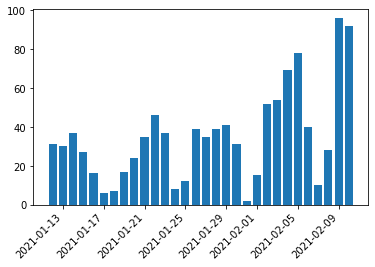

In [62]:
x = postings_df['post date']
y = postings_df['count']
fig = plt.figure()
plt.bar(x, y)
fig.autofmt_xdate()
plt.xticks(rotation=45)
plt.show()

## Analysis of Job Locations

In [111]:
jobs = indeed_df.copy()

In [112]:
jobs.loc[jobs['remote'],'search_location'] = 'Remote'

### Jobs Posted within the last 30 days

In [113]:
jobs.loc[jobs['posted_days_ago']<30,:].groupby('search_location')['indeed_job_key'].count()

search_location
Charlotte, NC         40
Chicago, IL          137
Los Angeles, CA      106
New York, NY         306
Phoenix, AZ           31
Remote               161
San Francisco, CA    273
Name: indeed_job_key, dtype: int64

### All Jobs on the Market

In [114]:
jobs.groupby('search_location')['indeed_job_key'].count()

search_location
Charlotte, NC         77
Chicago, IL          314
Los Angeles, CA      269
New York, NY         754
Phoenix, AZ           69
Remote               325
San Francisco, CA    694
Name: indeed_job_key, dtype: int64